<a href="https://colab.research.google.com/github/hmtrii/tirg/blob/main/Retrieve_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TIRG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/hmtrii/tirg.git

Cloning into 'tirg'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 83 (delta 43), reused 63 (delta 26), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [ ]:
!rm -rf /content/Fashion200k
!mkdir /content/Fashion200k
!cp -r /content/drive/MyDrive/TIRG/dataset/fashion-200k/labels /content/Fashion200k
!cp /content/drive/MyDrive/TIRG/dataset/test_queries.txt /content/Fashion200k
!mkdir /content/Fashion200k/women

In [ ]:
!tar -xf /content/drive/MyDrive/TIRG/dataset/fashion-200k/women.tar.gz -C /content/Fashion200k/women

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 11.4MB/s 


In [ ]:
!pip install torch==1.2.0 torchvision==0.4.0    

     |████████████████████████████████| 748.9MB 22kB/s 
     |████████████████████████████████| 8.8MB 25.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
!pip install Pillow==5.2.0

     |████████████████████████████████| 2.0MB 10.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


#Compute

In [ ]:
cd /content/tirg

/content/tirg


In [ ]:
from test_retrieval import test
from main import load_dataset, create_model_and_optimizer
from tools import pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import PIL

In [ ]:
class Opt:
    def __init__(self):
        self.dataset = "fashion200k"
        self.dataset_path = "/content/Fashion200k"
        self.batch_size = 32
        self.embed_dim = 512
        self.hashing = True
        self.retrieve_by_random = True
        self.model = "tirg"
        self.learning_rate = 1e-2
        self.weight_decay = 1e-6
        self.pretrained_model = "/content/drive/MyDrive/TIRG/checkpoint_fashion200k.pth"

In [ ]:
opt = Opt()
trainset, testset = load_dataset(opt)
model, _ = create_model_and_optimizer(opt, [t for t in trainset.get_all_texts()])
model.eval()

In [ ]:
all_imgs_feature = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/all_imgs_feature.pkl")
all_captions = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/all_captions.pkl")
all_queries_feature = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/all_queries_feature.pkl")
all_target_captions = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/all_target_captions.pkl")
img_ids = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/img_ids.pkl")
mods = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/mods.pkl")
all_norm_imgs_feature = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/all_norm_imgs_feature.pkl")
all_norm_queries_feature = pkl.pkl_load("/content/drive/MyDrive/TIRG/pkl/all_norm_queries_feature.pkl")

#Retrieve a random query

In [ ]:
test_queries = testset.get_test_queries()
sims = all_norm_queries_feature[:3000].dot(all_norm_imgs_feature.T)
for i, t in enumerate(test_queries):
    try:
        sims[i, t['source_img_id']] = -10e10
    except:
        pass
nn_result = [np.argsort(-sims[i, :])[:100] for i in range(sims.shape[0])]

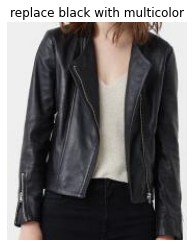

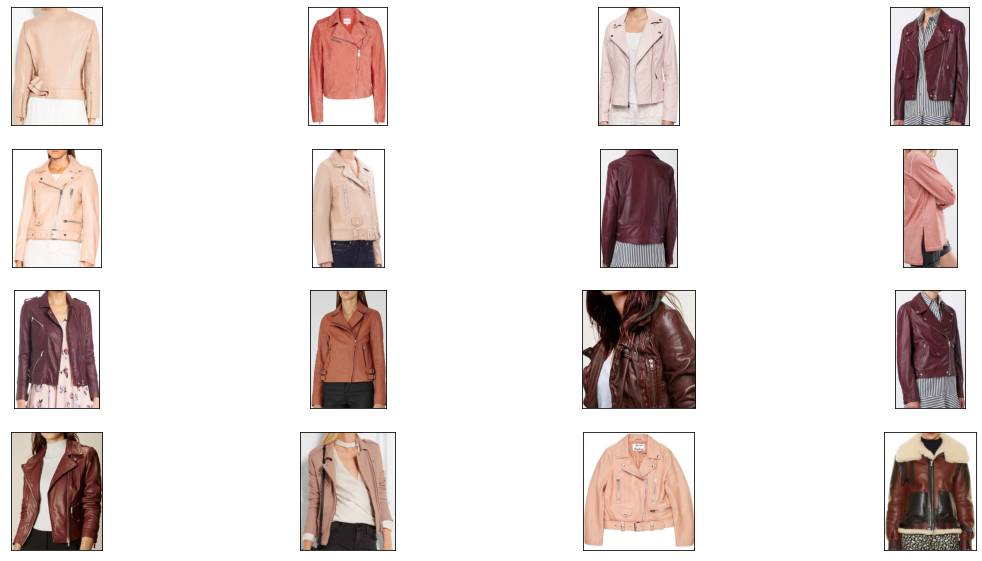

In [ ]:
chosen_idx = np.random.randint(0, 3000)
true_idx = img_ids[chosen_idx]
im = testset.get_img(true_idx, raw_img=True)
plt.imshow(im)
plt.axis("off")
mod = mods[chosen_idx]
plt.title(mod)

# Plot output
plt.figure(figsize=(20,10))
plt.axis('off')
width = 4
height = 4
for i in range(width*height):
    plt.subplot(width,height,i+1)
    plt.xticks([])
    plt.yticks([])
    idx = nn_result[chosen_idx][i]
    # print(idx)
    img = testset.get_img(int(idx), raw_img=True)
    plt.imshow(img)
    
    if idx == all_target_captions[chosen_idx]:
        plt.title("GT")
plt.show()

#Retrieve a custom query

In [ ]:
transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                                [0.229, 0.224, 0.225])
            ])

In [ ]:
with open("/content/drive/MyDrive/TIRG/thayhuan.png","rb") as f:
    query_img_raw = PIL.Image.open(f).convert("RGB")
query_img = transform(query_img_raw)
query_img = [query_img]
query_img = torch.stack(query_img).float()
query_img = torch.autograd.Variable(query_img).cuda()
query_text = ["replace red with brown"]

query_feature = model.compose_img_text(query_img, query_text).data.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


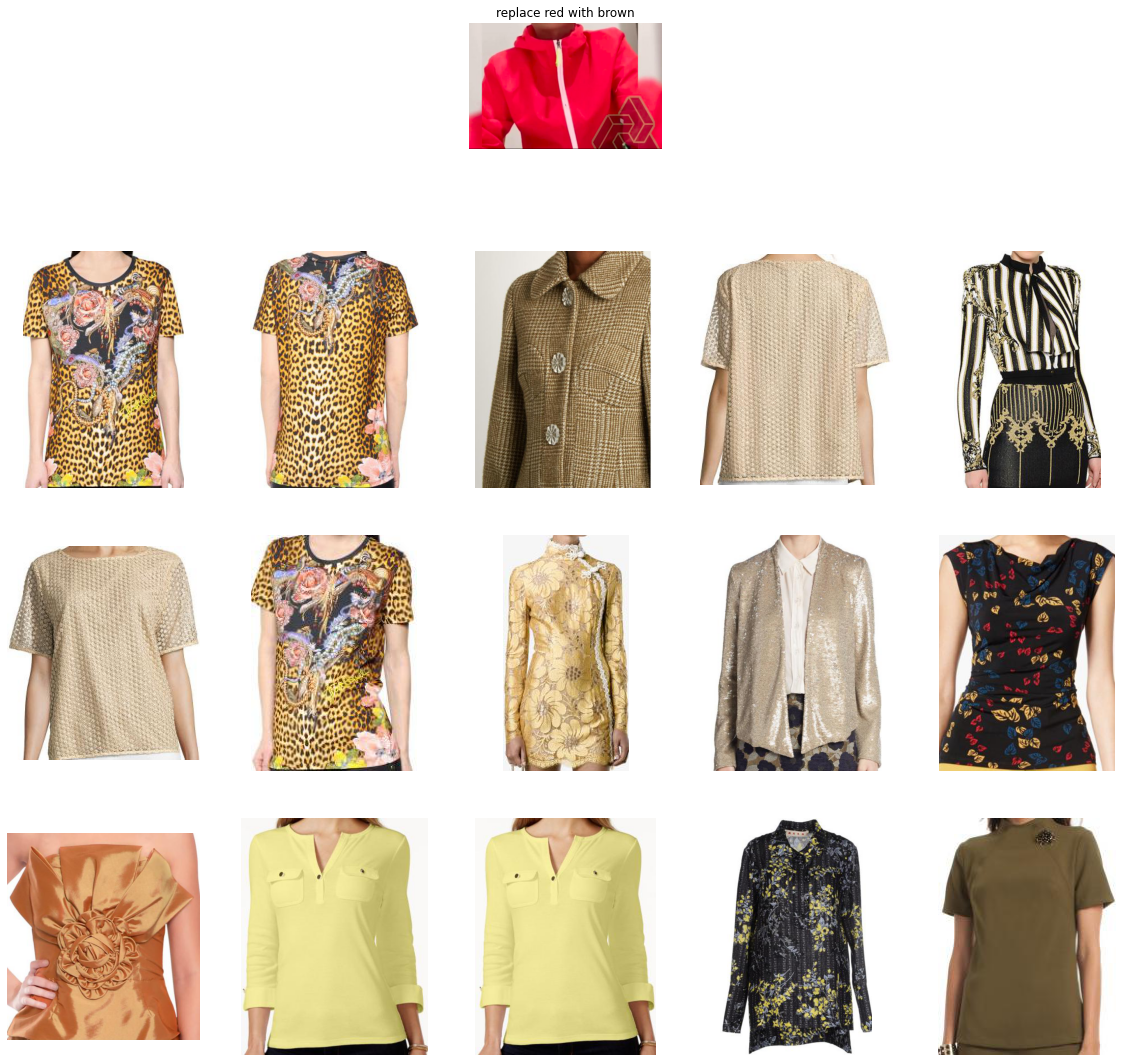

In [ ]:
sims = query_feature.dot(all_norm_imgs_feature.T)
nn_result = np.argsort(-sims[0, :])[:100]

c = 5
r = 4
fig = plt.figure(figsize=(20, 20))
# Show query
fig.add_subplot(r, c, 3)
plt.imshow(query_img_raw)
plt.title(query_text[0])
plt.axis("off")
# Show output
k = 15
for i in range(k):
    img = testset.get_img(int(nn_result[i]), raw_img=True)
    fig.add_subplot(r, c, i+6)
    plt.imshow(img)
    plt.axis('off')

plt.show()